In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("../data/total_data.csv")

In [2]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [3]:
df.rename(columns={"full_date": "date_time",
                  "pm": "value"}, inplace=True)

In [4]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
from functions import holt_winters_imputation_and_expand, plot_imputation_results

In [6]:
import sktime
from matplotlib import pyplot
import matplotlib as plt
import seaborn
import datetime
import pandas as pd
import statsmodels
import numpy as np

In [7]:
df.set_index("date_time", inplace=True)

df.index = pd.to_datetime(df.index)

# Generate the complete range of dates
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Reindex the DataFrame to include all dates
df = df.reindex(full_range)

# Set the index name back (optional)
df.index.name = 'date_time'

In [8]:
# df['value'] = holt_winters_imputation_and_expand(
#     df['value'],
#     seasonal_periods=365,
# )
# df.to_csv("../data/imputed_mean.csv")

In [9]:
df = pd.read_csv("../data/imputed_mean.csv")

In [10]:
df.set_index("date_time", inplace=True)

In [34]:
test_date = "2020-03-01"
test_date = "2020-01-01"
test_date = "2019-01-01"
test_date = "2018-01-01"
df_train = df[df.index < test_date].copy()
df_test = df[df.index >= test_date].copy()

In [35]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

from sklearn.metrics import mean_squared_error

def evaluate_on_test(y_hat, y_true):
    return mape(y_true, y_hat), np.sqrt(mean_squared_error(y_hat, y_true))

def plot_preds(y_hat, y_true):
    predictions = pd.DataFrame({
        "Preds": y_hat,
        "Actual": y_true,
        # "train": t['value']
    })
    _, ax = pyplot.subplots()
    ax = predictions.plot(ax=ax)

## Seasonal naive 

In [36]:
from statsforecast.models import SeasonalNaive
from statsforecast.core import StatsForecast
import pandas as pd

# Prepare your data
data = pd.DataFrame({'ds': df_train.index,
                     'y': df_train['value'].values})
data['unique_id'] = "mean"

# Specify the seasonal period (365 for daily data with yearly seasonality)
naive_metrics = {}
for length in range(355, 377):
    model = SeasonalNaive(season_length=length)
    model = model.fit(y=data['y'])
    y_hat_dict = model.predict(h=len(df_test['value']))
    metrics = evaluate_on_test(y_hat_dict['mean'], df_test['value'])
    naive_metrics[length] = [metrics, y_hat_dict['mean']]

ValueError: Input contains NaN.

In [ ]:
from statsforecast.models import SeasonalNaive
from statsforecast.core import StatsForecast
import pandas as pd

# Prepare your data
data = pd.DataFrame({'ds': df_train.index,
                     'y': df_train['value'].values})
data['unique_id'] = "mean"

# Specify the seasonal period (365 for daily data with yearly seasonality)
naive_metrics = {}
for length in range(355, 377):
    model = SeasonalNaive(season_length=length)
    model = model.fit(y=data['y'])
    y_hat_dict = model.predict(h=len(df_test['value']))
    metrics = evaluate_on_test(y_hat_dict['mean'], df_test['value'])
    naive_metrics[length] = [metrics, y_hat_dict['mean']]

(185.43055106122927, 63.13830982879899)


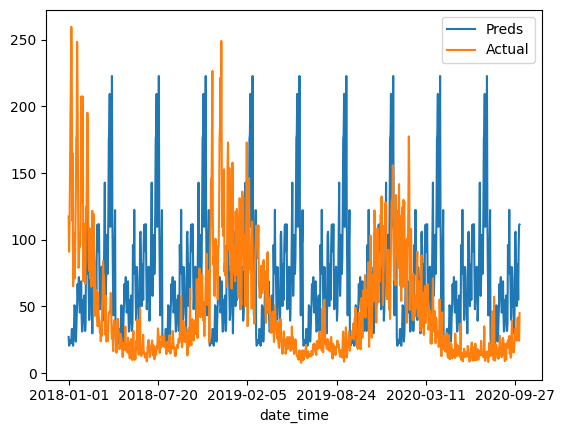

In [ ]:
v = list(naive_metrics.values())
m_mape = [m[0][0] for m in v]
m_rmse = [m[0][1] for m in v]

lens = range(355, 377)
print(naive_metrics[lens[np.argmin(m_mape)]][0])
plot_preds(naive_metrics[lens[np.argmin(m_mape)]][1], df_test['value'])

## Statistical models

In [28]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from scipy.special import boxcox1p, inv_boxcox1p
import itertools
import warnings

class TimeSeriesPreprocessor:
    def __init__(self, seasonal_period=365):
        self.seasonal_period = seasonal_period
        self.trend = None
        self.seasonality = None
        self.lambda_param = None
        self.mean = None
        self.std = None
        self.lambdas = None
        self.original_first_value = None
        
    def kpss_test(self, series):
        try:
            statistic, p_value, _, _ = kpss(series, regression='c')
            return p_value < 0.05  # Return True if the series is not stationary
        except Exception as e:
            warnings.warn(f"KPSS test failed: {e}")
            return False
        
    def determine_seasonal_differencing(self, series, fs_threshold=0.64):
        try:
            decomposition = seasonal_decompose(series, period=self.seasonal_period)
            seasonal_strength = 1 - (np.var(decomposition.resid) / np.var(decomposition.seasonal + decomposition.resid))
            return 1 if seasonal_strength >= fs_threshold else 0
        except Exception as e:
            warnings.warn(f"Failed to determine seasonal differencing: {e}")
            return 0

    def remove_trend(self, series, method='diff'):
        try:
            if method == 'decomposition':
                decomposition = seasonal_decompose(series, period=self.seasonal_period)
                self.trend = decomposition.trend
                return series - decomposition.trend
            elif method == 'diff':
                self.original_first_value = series[0]
                return np.diff(series, prepend=series[0])
        except Exception as e:
            warnings.warn(f"Failed to remove trend: {e}")
            return series

    def remove_seasonality(self, series):
        try:
            decomposition = seasonal_decompose(series, period=self.seasonal_period)
            self.seasonality = decomposition.seasonal
            return series - decomposition.seasonal
        except Exception as e:
            warnings.warn(f"Failed to remove seasonality: {e}")
            return series

    def apply_boxcox(self, series, lambda_param=None):
        try:
            if lambda_param is None:
                self.lambda_param = stats.boxcox_normmax(series + 1)
            else:
                self.lambda_param = lambda_param
            return boxcox1p(series, self.lambda_param), self.lambda_param
        except Exception as e:
            warnings.warn(f"Failed to apply Box-Cox transformation: {e}")
            return series, -1

    def apply_log(self, series):
        try:
            if (series <= 0).any():
                warnings.warn("Log transformation requires all values to be positive. Skipping log transformation.")
                return series
            return np.log(series)
        except Exception as e:
            warnings.warn(f"Failed to apply log transformation: {e}")
            return series

    def standardize(self, series):
        try:
            self.mean = series.mean()
            self.std = series.std()
            return (series - self.mean) / self.std
        except Exception as e:
            warnings.warn(f"Failed to standardize series: {e}")
            return series

    def fit_transform(self, series, remove_trend=True, remove_seasonality=True, 
                     apply_boxcox=False, apply_log=False, standardize=False, trend_method='diff'):
        transformed = series.copy()
        self.transforms = []
        
        if remove_trend:
            transformed = self.remove_trend(transformed, method=trend_method)
            self.transforms.append('trend')
            
        if remove_seasonality:
            seasonal_diffs = self.determine_seasonal_differencing(transformed)
            if seasonal_diffs > 0:
                transformed = np.diff(transformed, n=seasonal_diffs)
            else:
                transformed = self.remove_seasonality(transformed)
            self.transforms.append('seasonality')
            
        if apply_boxcox:
            transformed, _ = self.apply_boxcox(transformed)
            self.transforms.append('boxcox')
            
        if apply_log:
            transformed = self.apply_log(transformed)
            self.transforms.append('log')

        if standardize:
            transformed = self.standardize(transformed)
            self.transforms.append('standardize')
            
        return transformed

    def inverse_transform_predictions(self, predictions):
        transformed = predictions.copy()

        if 'standardize' in self.transforms:
            transformed = (transformed * self.std) + self.mean

        if 'log' in self.transforms:
            transformed = np.exp(transformed)

        if 'boxcox' in self.transforms:
            if self.lambda_param != -1:
                transformed = inv_boxcox1p(transformed, self.lambda_param)

        if 'seasonality' in self.transforms:
            start_idx = len(self.trend) % self.seasonal_period if self.trend is not None else 0
            seasonal_indices = np.arange(start_idx, start_idx + len(predictions)) % self.seasonal_period
            seasonal_pattern = self.seasonality[seasonal_indices]
            transformed = transformed + seasonal_pattern

        if 'trend' in self.transforms:
            if hasattr(self, 'original_first_value'):
                reversed_series = np.cumsum(transformed)
                transformed = reversed_series + self.original_first_value
            else:
                warnings.warn("Trend removal used differencing, but original_first_value is not set. Skipping trend reversal.")
        
        return transformed

    def create_pipeline(self, series, steps):
        """
        steps: list of transformations ['trend', 'seasonality', 'boxcox', 'log', 'standardize']
        Returns: dict with all possible combinations of transformations
        """
        results = {'original': series.copy()}

        self.lambdas = {}
        
        for r in range(1, len(steps) + 1):
            for combo in itertools.combinations(steps, r):
                transformed = series.copy()
                name = []
                
                for step in combo:
                    if step == 'trend':
                        transformed = self.remove_trend(transformed)
                        name.append('trend')
                    elif step == 'seasonality':
                        transformed = self.remove_seasonality(transformed)
                        name.append('seasonality')
                    elif step == 'boxcox':
                        transformed, lambda_param = self.apply_boxcox(transformed)
                        self.lambdas["_".join(combo)] = lambda_param

                        name.append('boxcox')
                    elif step == 'log':
                        transformed = self.apply_log(transformed)
                        name.append('log')
                    elif step == 'standardize':
                        transformed = self.standardize(transformed)
                        name.append('standardize')
                    
                    transformed = transformed[~np.isnan(transformed)]

                transformed = transformed[~np.isnan(transformed)]
                results['_'.join(name)] = transformed
                
        return results


In [29]:
def train_test_split(series, test_size=0.2):
    """
    Splits the series into train and test sets.

    Parameters:
        series (array-like): The transformed series to split.
        test_size (float): Proportion of the series to include in the test set (default: 0.2).
    
    Returns:
        tuple: (train_series, test_series)
    """
    try:
        n = len(series)
        test_count = int(n * test_size)
        train_series = series[:-test_count]
        test_series = series[-test_count:]
        return train_series, test_series
    except Exception as e:
        warnings.warn(f"Failed to split series into train and test sets: {e}")
        return series, None


In [30]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# data = preprocessor.remove_seasonality(data)
# data = data[~np.isnan(data)]
# result = seasonal_decompose(data, model='additive', period=300)
# result.plot()
# pyplot.show()

In [ ]:
data = df['value'].values.copy()
preprocessor = TimeSeriesPreprocessor(seasonal_period=365)

steps = ['log', 'trend', 'seasonality', 'boxcox', 'standardize']
transformed_series = preprocessor.create_pipeline(data, steps)

C:\Users\77019\AppData\Local\Temp\ipykernel_4500\3545460389.py:68: UserWarning: Failed to apply Box-Cox transformation: The `x` argument of `boxcox_normmax` must contain only positive, finite, real numbers.
  warnings.warn(f"Failed to apply Box-Cox transformation: {e}")


In [32]:
import pandas as pd
import numpy as np
from statsforecast.models import (
    AutoETS, AutoARIMA, SeasonalExponentialSmoothingOptimized, 
    AutoTheta, CrostonClassic, CrostonSBA,
    AutoTBATS, SeasonalExponentialSmoothing, HoltWinters, Holt, 
    SeasonalWindowAverage, ADIDA, CrostonOptimized, IMAPA, TSB
)
from sklearn.metrics import mean_absolute_error, mean_squared_error

def compare_models(data_train, data_test, season_length=365):
    # Prepare data
    # data_train = df_train['value'].values
    # data_test = df_test['value'].values
    
    # Model configurations with flexible initialization
    models = [
        ('AutoETS', lambda: AutoETS().fit(data_train).predict(len(data_test))),
        ('AutoARIMA', lambda: AutoARIMA().fit(data_train).predict(len(data_test))),
        ('AutoTheta', lambda: AutoTheta().fit(data_train).predict(len(data_test))),
        ('CrostonClassic', lambda: CrostonClassic().fit(data_train).predict(len(data_test))),
        ('CrostonSBA', lambda: CrostonSBA().fit(data_train).predict(len(data_test))),
        # ('AutoTBATS', lambda: AutoTBATS(season_length=season_length).fit(data_train).predict(len(data_test))),
        # ('SeasonalExponentialSmoothing', lambda: SeasonalExponentialSmoothing(season_length=season_length, alpha=0.8).fit(data_train).predict(len(data_test))),
        # ('SeasonalExponentialSmoothingOptimized', lambda: SeasonalExponentialSmoothing(season_length=season_length, alpha=0.8).fit(data_train).predict(len(data_test))),
        ('HoltWinters', lambda: HoltWinters().fit(data_train).predict(len(data_test))),
        ('Holt', lambda: Holt().fit(data_train).predict(len(data_test))),
        # ('SeasonalWindowAverage', lambda: SeasonalWindowAverage(window_size=300, season_length=season_length).fit(data_train).predict(len(data_test))),
        ('ADIDA', lambda: ADIDA().fit(data_train).predict(len(data_test))),
        ('CrostonOptimized', lambda: CrostonOptimized().fit(data_train).predict(len(data_test))),
        ('IMAPA', lambda: IMAPA().fit(data_train).predict(len(data_test))),
    ]
    
    # Store results
    results = {}
    
    # Predict and evaluate each model
    for name, model_func in models:
        try:
            # Predict using lambda function
            y_hat = model_func()['mean']
            
            # Calculate metrics
            mae = mean_absolute_error(data_test, y_hat)
            mse = mean_squared_error(data_test, y_hat)
            rmse = np.sqrt(mse)
            
            results[name] = {
                'MAE': mae,
                'MAPE': mape(data_test, y_hat),
                'MSE': mse,
                'RMSE': rmse,
                'Predictions': y_hat
            }
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
    
    # Find the best model based on RMSE
    best_model = min(results, key=lambda x: results[x]['RMSE'])
    
    return results, best_model

# Usage example
# results, best_model = compare_models(df_train, df_test)
# print(f"Best Model: {best_model}")
# print("Model Performance Metrics:", results[best_model])

173.2973297898052


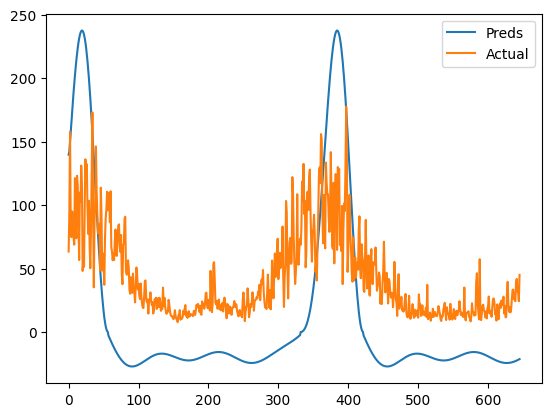

In [33]:
y_true = df_test['value'].values.copy()

model = AutoTBATS(season_length=365)
model = model.fit(df_train['value'].values)
y_hat = model.predict(len(y_true))['mean']

print(mape(y_true, y_hat))
plot_preds(y_hat, y_true)

In [22]:
distr_model_dict = {}

for name, series in transformed_series.items():
    train_series, test_series = train_test_split(transformed_series[name], 0.2)
    
    results, best_model = compare_models(train_series, test_series)

    print(name)
    print(f"Best Model: {best_model}")
    print("Model Performance Metrics:", results[best_model]['MAPE'], results[best_model]['RMSE'])

    if results[best_model]['MAPE'] < 50:
        distr_model_dict[name] = [best_model, train_series, test_series, results[best_model]['Predictions']]

Error with HoltWinters: Nonseasonal data
original
Best Model: CrostonSBA
Model Performance Metrics: 378.54662522750687 70.1658570627508
Error with HoltWinters: Nonseasonal data
log
Best Model: CrostonSBA
Model Performance Metrics: 42.71289878054167 1.332402318645925
Error with HoltWinters: Nonseasonal data
trend
Best Model: AutoETS
Model Performance Metrics: 100.24335585152176 15.508994589867482
Error with HoltWinters: Nonseasonal data
seasonality
Best Model: CrostonClassic
Model Performance Metrics: 42.89676067591752 14.681059138617963
Error with HoltWinters: Nonseasonal data
boxcox
Best Model: CrostonSBA
Model Performance Metrics: 13.583430242991259 0.2753401810688954
Error with HoltWinters: Nonseasonal data
standardize
Best Model: CrostonSBA
Model Performance Metrics: 1027.0534360272397 1.8067842547539181
Error with HoltWinters: Nonseasonal data
log_trend
Best Model: AutoARIMA
Model Performance Metrics: 102.33483724196827 0.42466555117693305
Error with HoltWinters: Nonseasonal data


KeyboardInterrupt: 

In [ ]:
orig_train, orig_test = train_test_split(df['value'])

In [ ]:
from copy import deepcopy

for distr_name, res in distr_model_dict.items():
    distr_preprocessor = deepcopy(preprocessor)
    distr_preprocessor.transforms = distr_name.split('_')

    if "boxcox" in distr_name:
        distr_preprocessor.lambda_param = preprocessor.lambdas[distr_name]

    print(distr_name)

    orig_preds = distr_preprocessor.inverse_transform_predictions(res[-1])

    if len(set(orig_preds)) > 1: 
        print(mape(orig_test, orig_preds))

log
seasonality
127.46834056292806
boxcox
log_seasonality
79.88525999379137
log_boxcox
nan
seasonality_boxcox
127.46834056292806
log_seasonality_boxcox
95.48704173180278


In [ ]:
import numpy as np
import itertools
from sklearn.metrics import mean_squared_error

def tune_hyperparameters(data_train, data_test):
    # data_train = df_train['value'].values
    # data_test = df_test['value'].values

    # Hyperparameter search spaces
    season_length_range = range(357, 368)

    # Smoothing Models Tuning
    best_smoothing_params = {}
    smoothing_results = {}
    smoothing_predictions = {}

    for season_length in season_length_range:
        try:
            model = SeasonalExponentialSmoothingOptimized(season_length=season_length)
            fitted_model = model.fit(data_train)
            y_hat = fitted_model.predict(len(data_test))['mean']
            smoothing_results[season_length] = mape(data_test, y_hat)
            smoothing_predictions[season_length] = y_hat  # Save predictions
        except Exception as e:
            print(f"Smoothing model error: {e}")

    best_smoothing_season_length = min(smoothing_results, key=smoothing_results.get)
    best_smoothing_params['smoothing'] = best_smoothing_season_length
    best_smoothing_params['smoothing_y_hat'] = smoothing_predictions[best_smoothing_season_length]  # Save best predictions
    print('Best smoothing:', smoothing_results[best_smoothing_season_length])

    # AutoTBATS Season Length Tuning
    tbats_results = {}
    tbats_predictions = {}

    for season_length in season_length_range:
        try:
            model = AutoTBATS(season_length=season_length)
            fitted_model = model.fit(data_train)
            y_hat = fitted_model.predict(len(data_test))['mean']
            tbats_results[season_length] = mape(data_test, y_hat)
            tbats_predictions[season_length] = y_hat  # Save predictions
        except Exception as e:
            print(f"AutoTBATS error: {e}")

    best_tbats_season_length = min(tbats_results, key=tbats_results.get)
    best_smoothing_params['tbats_season_length'] = best_tbats_season_length
    best_smoothing_params['tbats_y_hat'] = tbats_predictions[best_tbats_season_length]  # Save best predictions
    print('Best TBATS:', tbats_results[best_tbats_season_length])

    return best_smoothing_params

In [170]:
best_seasonal_params = {}

for distr_name, vals in distr_model_dict.items():    
    print(distr_name)
    best_seasonal_params[distr_name] = tune_hyperparameters(vals[1], vals[2])

log
Best smoothing: 12.6359954795594
Best TBATS: 9.277090541014315
seasonality
Best smoothing: 60.76711693541391


c:\Users\77019\pyver\py312\Lib\site-packages\statsforecast\tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\statsforecast\tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\statsforecast\tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\statsforecast\tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\statsforecast\tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\statsforecast\tbats.py:949: UserWarning: Data contains zero or negative val

Best TBATS: 45.898916212209066
boxcox
Best smoothing: 5.804630028740742
Best TBATS: 4.505210665315312
log_seasonality
Best smoothing: 11.421113683672962
Best TBATS: 9.078812471177292
log_boxcox
Best smoothing: 3.9172042256307797
Best TBATS: 3.0536032135802813
seasonality_boxcox
Best smoothing: 60.76711693541391


c:\Users\77019\pyver\py312\Lib\site-packages\statsforecast\tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\statsforecast\tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\statsforecast\tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\statsforecast\tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\statsforecast\tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\statsforecast\tbats.py:949: UserWarning: Data contains zero or negative val

Best TBATS: 45.898916212209066
log_seasonality_boxcox
Best smoothing: 12.571524053362046
Best TBATS: 9.9696543985302


log
Best Model: CrostonSBA
Model Performance Metrics: 42.71289878054167 1.332402318645925

seasonality
Best Model: CrostonClassic
Model Performance Metrics: 42.89676067591752 14.681059138617963

boxcox
Best Model: CrostonSBA
Model Performance Metrics: 13.583430242991259 0.2753401810688954

log_seasonality
Best Model: AutoARIMA
Model Performance Metrics: 8.687792350235913 0.3756859571388092

log_boxcox
Best Model: CrostonSBA
Model Performance Metrics: 7.7512181540748735 0.08182107183704744

seasonality_boxcox
Best Model: CrostonClassic
Model Performance Metrics: 42.89676067591752 14.681059138617963

log_seasonality_boxcox
Best Model: AutoARIMA
Model Performance Metrics: 9.51121993015499 0.4785173520188582

In [177]:
promising_distrs = ['log', 'boxcox', 'log_boxcox']

for distr_name in promising_distrs:
    distr_preprocessor = deepcopy(preprocessor)
    distr_preprocessor.transforms = distr_name.split('_')

    if "boxcox" in distr_name:
        distr_preprocessor.lambda_param = preprocessor.lambdas[distr_name]

    orig_preds = distr_preprocessor.inverse_transform_predictions(best_seasonal_params[distr_name]['tbats_y_hat'])

    if len(set(orig_preds)) > 1: 
        print(mape(orig_test, orig_preds))

30.85731504712218
31.93596547331979
nan


In [126]:
y_true = df_test['value'].values.copy()

model = SeasonalExponentialSmoothingOptimized(season_length=362)
model = model.fit(df_train['value'].values)
y_hat = model.predict(len(y_true))['mean']

print(mape(y_true, y_hat))
# plot_preds(y_hat, y_true)

47.72315132238752


26.437993898889516


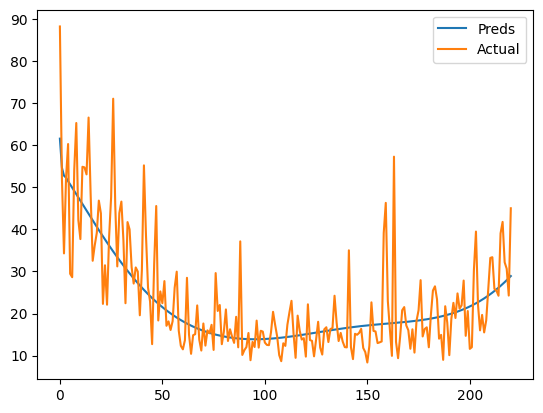

In [96]:
y_true = df_test['value'].values.copy()

model = AutoTBATS(season_length=365)
model = model.fit(df_train['value'].values)
y_hat = model.predict(len(y_true))['mean']

print(mape(y_true, y_hat))
plot_preds(y_hat, y_true)